# Creating a list of CE and PE Pain values for all the instruments

In [5]:
import numpy as np
import pandas as pd
import datetime 
import csv
import os
import time
s=time.time()

#################################################################################################################################

def createKeys(df):
    ''' Creates the keys, sets it as index , groups the dataframe according to a stock and its expiry'''
    df.sort_values(by = ['KEY'], inplace = True)
    
    
    df['Whatever'] = df['KEY'].apply(lambda x: x.split("_")[0] + "_" + x.split("_")[1])
    df['STRIKE_PRICE'] = df['KEY'].apply(lambda x: float(x.split("_")[2]))
    df['STRIKE_PR'] = df['STRIKE_PRICE']
    df['OPTION_TYP'] = df['KEY'].apply(lambda x: x.split("_")[3])
    
    
    
    df.set_index(keys = ['Whatever','KEY'], inplace= True)
    return df

#################################################################################################################################



def strikeMatrix(df):
    

    t1 = time.time()
    
    groups = df.groupby( level =0 )


    list1D_CE = []
    list_of_groups_PE=[]
    list_of_groups_CE=[]
    
    for name, group in groups:


        list1D_CE.append(group[group['OPTION_TYP']=='CE'].STRIKE_PR.tolist())
        list_of_groups_CE.append(group[group['OPTION_TYP']=='CE'])
        list_of_groups_PE.append(group[group['OPTION_TYP']=='PE'])
    
    #list_of_list2D_CE = []
    #list_of_list2D_PE = []

    t2 = time.time()
    #print("Grouping ka time: {}".format(t2-t1))
    
    list_3D_CE_PE= []    
    for strikelist in list1D_CE: #for CE
        list2D_CE=[]
        list2D_PE = []
        
        temp = []
        
        for i in strikelist:
            for j in strikelist:
                if j-i > 0:
                    list2D_CE.append(i-j)
                    list2D_PE.append(0)
                    
                else:
                    list2D_PE.append(j-i)
                    list2D_CE.append(0)
                    
        list2D_CE = np.array(list2D_CE)
        list2D_CE=list2D_CE.reshape(len(strikelist), len(strikelist))

        #list_of_list2D_CE.append(list2D_CE)             
                    
        list2D_PE = np.array(list2D_PE)
        list2D_PE=list2D_PE.reshape(len(strikelist), len(strikelist))
        
        temp.append(list2D_CE)
        temp.append(list2D_PE)
        
        list_3D_CE_PE.append(temp)
        
        #list_of_list2D_PE.append(list2D_PE)
        
        
              
                 
    t3 = time.time()
    #print("for ka time: {}".format(t3-t2))
                   

    return (list_of_groups_CE, list_of_groups_PE, list_3D_CE_PE)

#################################################################################################################################


#Creating the file list
flist = [file for file in os.listdir('C:\\Users\\Mohit Aneja\\Desktop\\Mohit Project_Quantsapp\\FILES') if file.endswith('.csv')]

for file in flist:
    
    number = str(file).split(".")[0] #taking out the number from the file name
    int_num = int(number)
    df_2 = pd.read_csv( number + '.csv') ################
    df_2['KEY'].dropna(inplace = True)
    df_2 = createKeys(df_2)
    if int_num > 1:
        
        df_2['AVG_PRICE' + number].fillna(0, inplace = True) ################
    #print(df_2)




    list_of_groups_CE, list_of_groups_PE, master_list  = strikeMatrix(df_2)

    

    i=0
    list_of_list_of_strikes= []
    list_of_list_of_sum_pd_ce = []
    list_of_list_of_sum_pd_pe = []

    time_list = []
    time_list.append(time.time())
    time_var  = 0
    for lists in master_list:
        
        #t4b=time.time()
        df_3_CE = pd.DataFrame(lists[0])
        df_3_PE = pd.DataFrame(lists[1])


        df_option_avg_CE = list_of_groups_CE[i] #for every group, will read the old calculation file
        df_option_avg_PE = list_of_groups_PE[i]
        #df_option_avg.head()
        #print(df_option_avg.columns)
        if int_num == 1:
            #df_option_avg_CE.rename(columns = {'CLOSE' + number : 'AVG_PRICE' + number }, inplace= True)
            #df_option_avg_PE.rename(columns = {'CLOSE' + number : 'AVG_PRICE' + number }, inplace= True)
            df_option_avg_CE["AVG_PRICE" + number] = df_option_avg_CE["CLOSE" + number].copy()
            df_option_avg_PE["AVG_PRICE" + number] = df_option_avg_PE["CLOSE" + number].copy()
        #print(number)
        #print(df_option_avg_CE.head())
        df_3_CE['AVERAGE_PRICE']= df_option_avg_CE['AVG_PRICE' + number].values ################
        df_3_PE['AVERAGE_PRICE']= df_option_avg_PE['AVG_PRICE' + number].values ################

        list_of_list_of_strikes.append(df_option_avg_CE.STRIKE_PR.values)

        df_3_CE['AVERAGE_PRICE'].fillna(0, inplace = True)
        df_3_PE['AVERAGE_PRICE'].fillna(0, inplace = True)

        #series_to_add_CE = df_3_CE['AVERAGE_PRICE'].copy()
        #series_to_add_PE = df_3_PE['AVERAGE_PRICE'].copy()

        for j in range(len(df_3_CE.columns)-1): #Will add average prices to the matrix
            df_3_CE[j] = df_3_CE['AVERAGE_PRICE']+ df_3_CE[j]
            df_3_PE[j] = df_3_PE['AVERAGE_PRICE']+ df_3_PE[j]

        df_3_CE['OI']= df_option_avg_CE['OI' + number].values ################
        df_3_PE['OI']= df_option_avg_PE['OI' + number].values ################

        df_3_CE[df_3_CE['OI'] == 0] = 0 
        df_3_PE[df_3_PE['OI'] == 0] = 0

        sum_products_CE=[]
        sum_products_PE=[]

        for k in range(len(df_3_CE.columns)-2):
            sum_products_CE.append(sum(df_3_CE[k]*df_3_CE['OI'].tolist()))
            sum_products_PE.append(sum(df_3_PE[k]*df_3_PE['OI'].tolist()))

        list_of_list_of_sum_pd_ce.append(sum_products_CE)
        list_of_list_of_sum_pd_pe.append(sum_products_PE)

        i = i+1
        #t4a = time.time()
        #print("DF ka time: {}".format(t4a-t4b))

    #t5 = time.time()
    #print("list_CE ka time: {}".format(t5-t4))
    
    groups = df_2.groupby(level = 0)
    #l = 0
    #for name, group in groups:
        #print(l, name)
        #l = l+1
        
        
    
    '''Printing the results for one particular group- BANKNIFTY 31-MAY-2018 EXPIRY''' #at index 76 in the ist printed below.
    
    df_BANKNIFTY = pd.DataFrame(list_of_list_of_strikes[76], columns = ['STRIKES'])
    df_BANKNIFTY['SUM_PD_PE'] = list_of_list_of_sum_pd_pe[76]
    df_BANKNIFTY['SUM_PD_CE'] = list_of_list_of_sum_pd_ce[76]
    list_of_pnl = []

    for kj in range(len(list_of_list_of_sum_pd_ce)):
        list_of_pnl.append(np.array(list_of_list_of_sum_pd_ce[kj])+ np.array(list_of_list_of_sum_pd_pe[kj]))
    
    df_BANKNIFTY['P&L'] = list_of_pnl[76]
    
    
    
    #WRITING TO EXCEL FILE
    df_BANKNIFTY.to_excel('P&L_'+ number + '_check_once_more_BANKNIFTY.xlsx', index= False) ################


    time_list.append(time.time())
    print("Processing of file - {} successful!".format(str(file))) #,time_list[time_var +1 ]-time_list[time_var]))
    time_var = time_var + 1


    
    
    
    
    

Processing of file - 1.csv successful!
Processing of file - 2.csv successful!
Processing of file - 3.csv successful!
Processing of file - 4.csv successful!
Processing of file - 5.csv successful!
Processing of file - 6.csv successful!


# Printing out all the instruments along with index

In [2]:
groups = df_2.groupby(level = 0)
l = 0
for name, group in groups:
    print(l, name)
    l = l+1

0 ACC_26-Jul-2018
1 ACC_28-Jun-2018
2 ACC_31-May-2018
3 ADANIENT_26-Jul-2018
4 ADANIENT_28-Jun-2018
5 ADANIENT_31-May-2018
6 ADANIPORTS_26-Jul-2018
7 ADANIPORTS_28-Jun-2018
8 ADANIPORTS_31-May-2018
9 ADANIPOWER_26-Jul-2018
10 ADANIPOWER_28-Jun-2018
11 ADANIPOWER_31-May-2018
12 AJANTPHARM_26-Jul-2018
13 AJANTPHARM_28-Jun-2018
14 AJANTPHARM_31-May-2018
15 ALBK_26-Jul-2018
16 ALBK_28-Jun-2018
17 ALBK_31-May-2018
18 AMARAJABAT_26-Jul-2018
19 AMARAJABAT_28-Jun-2018
20 AMARAJABAT_31-May-2018
21 AMBUJACEM_26-Jul-2018
22 AMBUJACEM_28-Jun-2018
23 AMBUJACEM_31-May-2018
24 ANDHRABANK_26-Jul-2018
25 ANDHRABANK_28-Jun-2018
26 ANDHRABANK_31-May-2018
27 APOLLOHOSP_26-Jul-2018
28 APOLLOHOSP_28-Jun-2018
29 APOLLOHOSP_31-May-2018
30 APOLLOTYRE_26-Jul-2018
31 APOLLOTYRE_28-Jun-2018
32 APOLLOTYRE_31-May-2018
33 ARVIND_26-Jul-2018
34 ARVIND_28-Jun-2018
35 ARVIND_31-May-2018
36 ASHOKLEY_26-Jul-2018
37 ASHOKLEY_28-Jun-2018
38 ASHOKLEY_31-May-2018
39 ASIANPAINT_26-Jul-2018
40 ASIANPAINT_28-Jun-2018
41 ASIANPA

In [3]:
df_BANKNIFTY = pd.DataFrame(list_of_list_of_strikes[76], columns = ['STRIKES'])
df_BANKNIFTY.head()

,STRIKES
0,22100.0
1,22200.0
2,22300.0
3,22400.0
4,22500.0


In [4]:
df_BANKNIFTY['SUM_PD_PE'] = list_of_list_of_sum_pd_pe[76]
df_BANKNIFTY['SUM_PD_CE'] = list_of_list_of_sum_pd_ce[76]

# Plotting the CE and PE Pain values of Banknifty 31-May-2018 Expiry

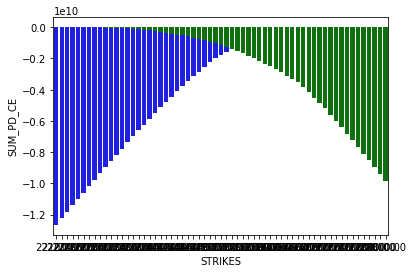

In [5]:
import seaborn as sns
%matplotlib inline
sns.barplot(x = df_BANKNIFTY['STRIKES'], y = df_BANKNIFTY['SUM_PD_PE'], color = 'b')
sns.barplot(x = df_BANKNIFTY['STRIKES'], y = df_BANKNIFTY['SUM_PD_CE'], color = 'g')

In [19]:
#df_BANKNIFTY.to_excel('2_BANKNIFTY_PAIN')

In [6]:
list_of_pnl = []

for kj in range(len(list_of_list_of_sum_pd_ce)):
    list_of_pnl.append(np.array(list_of_list_of_sum_pd_ce[kj])+ np.array(list_of_list_of_sum_pd_pe[kj]))
    
    
        
    


In [7]:
df_BANKNIFTY['P&L'] = list_of_pnl[76]

# Plotting the Effective Pain for Banknifty 31-May-2018 Expiry

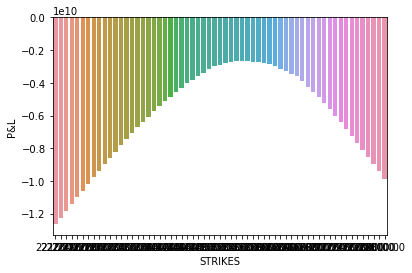

In [8]:
sns.barplot(x = df_BANKNIFTY['STRIKES'], y = df_BANKNIFTY['P&L'])

In [9]:
df_BANKNIFTY.to_excel('P&L_6_d_BANKNIFTY.xlsx', index= False) ################

In [33]:
list_of_list_of_strikes[76]

array([22100., 22200., 22300., 22400., 22500., 22600., 22700., 22800.,
       22900., 23000., 23100., 23200., 23300., 23400., 23500., 23600.,
       23700., 23800., 23900., 24000., 24100., 24200., 24300., 24400.,
       24500., 24600., 24700., 24800., 24900., 25000., 25100., 25200.,
       25300., 25400., 25500., 25600., 25700., 25800., 25900., 26000.,
       26100., 26200., 26300., 26400., 26500., 26600., 26700., 26800.,
       26900., 27000., 27100., 27200., 27300., 27400., 27500., 27600.,
       27700., 27800., 27900., 28000., 28100.])